In [95]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import illustris_python as il
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
import time
import scipy.linalg

In [2]:
basePath = 'data'

In [3]:
fields = ['SubhaloFlag', 'SubhaloMass','SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 
          'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions']
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=fields)

In [4]:
subhalos.keys()

dict_keys(['count', 'SubhaloFlag', 'SubhaloMass', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions'])

In [5]:
for i in range(3):
    subhalos['SubhaloPos'][:,i] = ((subhalos['SubhaloPos'][:,i]) * u.kpc).to(u.Mpc)

In [6]:
def impose_cut(subhalos, boolean_array):
    for key in subhalos.keys():
        if key != 'count':
            subhalos[key] = subhalos[key][boolean_array]
        else:
            subhalos[key] = sum(boolean_array)
    return subhalos

In [7]:
# subhalos = impose_cut(subhalos, subhalos['SubhaloMass']*1e10 >=1e9) # subhalo mass > 1e9 Msun
subhalos = impose_cut(subhalos, subhalos['SubhaloMassType'][:,4]*1e10 >=1e9) # subhalo mass > 1e9 Msun
subhalos = impose_cut(subhalos, subhalos['SubhaloFlag'] > 0) # is actually a subhalo
subhalos = impose_cut(subhalos, subhalos['SubhaloLenType'][:,4] > 100) # more than 50 star particles

In [8]:
subhalos['SubhaloPos'].shape

(17611, 3)

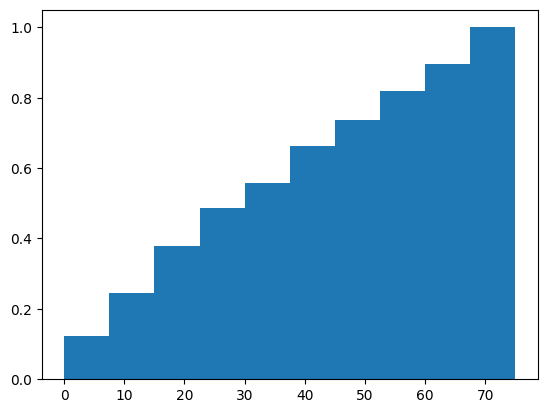

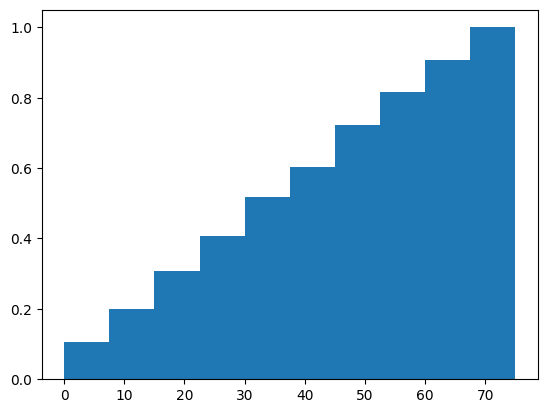

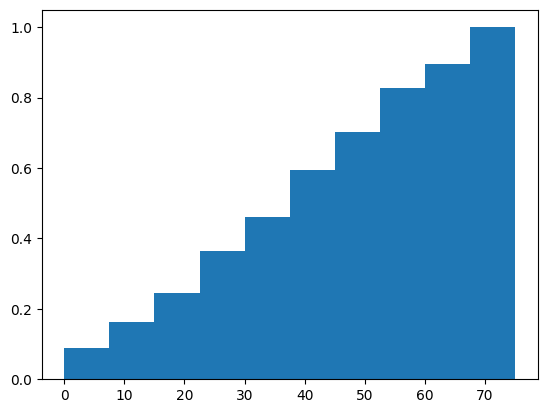

In [9]:
for i in range(3):
    plt.hist(subhalos['SubhaloPos'][:,i], cumulative=True, density=True)
    plt.show()

In [13]:
limit = 50
for i in range(3):
    subhalos = impose_cut(subhalos, subhalos['SubhaloPos'][:,i] < limit)

In [14]:
subhalos['count']

5745

In [15]:
subhalos['SubhaloPos']

array([[ 0.8490915 , 26.326998  , 18.306934  ],
       [ 0.10647334, 24.633324  , 16.900553  ],
       [ 0.8531124 , 26.72575   , 17.510681  ],
       ...,
       [12.101596  ,  0.7713217 ,  8.467401  ],
       [ 2.0424943 , 25.050951  , 18.758776  ],
       [12.748418  , 49.63988   , 47.6435    ]], dtype=float32)

In [16]:
t = time.time()
original_distance_matrix = euclidean_distances(subhalos['SubhaloPos'],subhalos['SubhaloPos']) # supposedly takes ~20 sec
print(time.time() - t)

0.132004976272583


(array([ 960139., 2701350., 5224984., 6863410., 6963152., 5904948.,
        3228232.,  974324.,  176366.,    8120.]),
 array([ 0.        ,  7.91180182, 15.82360363, 23.73540497, 31.64720726,
        39.55900955, 47.47080994, 55.38261414, 63.29441452, 71.2062149 ,
        79.1180191 ]),
 <BarContainer object of 10 artists>)

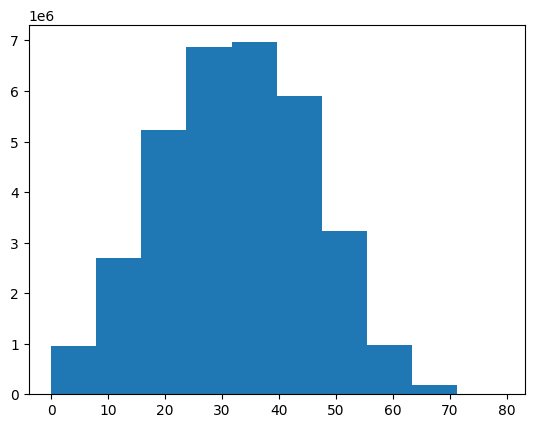

In [17]:
plt.hist(original_distance_matrix.flatten())

for every galaxy, calculate the distance to every other galaxy for every possible transformation, then pick the minimum.

In [18]:
h = limit / 2
possible_transforms = np.array([[0, 0, h], [0, h, 0], [h, 0, 0], [h, h, 0], [h, -h, 0], [0, h,h], [0, -h,h], [h, 0,h], [h, 0,-h], [h,h,h], [-h,h,h], [h,-h,h],[h,h,-h]])
possible_transforms = np.vstack(([0,0,0], possible_transforms, -possible_transforms))

In [19]:
possible_transforms.shape

(27, 3)

In [20]:
num_transforms = possible_transforms.shape[0]
possible_distances = np.zeros((num_transforms, subhalos['count'], subhalos['count']))

original_positions = subhalos['SubhaloPos']
for i in range(num_transforms):
    # print(i)
    possible_distances[i] = euclidean_distances(original_positions, original_positions + possible_transforms[i])

In [21]:
distance_matrix = np.min(possible_distances, axis=0)

In [22]:
possible_distances[:,2,3]

array([ 1.7445138 , 23.38689322, 24.85205287, 24.44709513, 34.81726101,
       35.11522828, 34.08119684, 34.38554305, 33.78703755, 36.10757558,
       41.90638508, 42.6252372 , 42.15427266, 43.79883809, 26.62968048,
       25.26780808, 25.65981676, 35.97005689, 35.67922925, 36.66822437,
       36.38297797, 36.93944707, 34.67462534, 44.72070602, 44.03607397,
       44.48712121, 42.86896825])

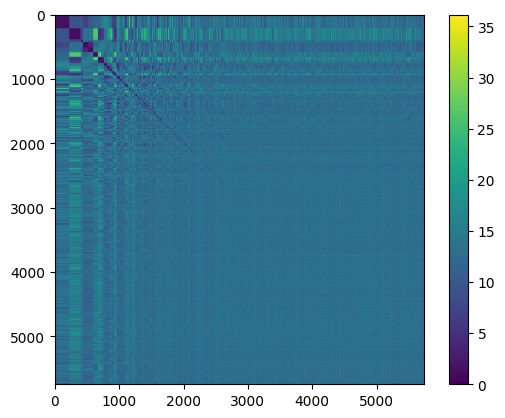

In [23]:
plt.imshow(distance_matrix)
plt.colorbar()

(array([6.088110e+05, 2.737254e+06, 6.728470e+06, 1.083892e+07,
        7.282220e+06, 2.787308e+06, 1.475266e+06, 4.778960e+05,
        6.351400e+04, 5.366000e+03]),
 array([ 0.        ,  3.61497864,  7.22995729, 10.84493593, 14.45991458,
        18.07489322, 21.68987187, 25.30485051, 28.91982915, 32.5348078 ,
        36.14978644]),
 <BarContainer object of 10 artists>)

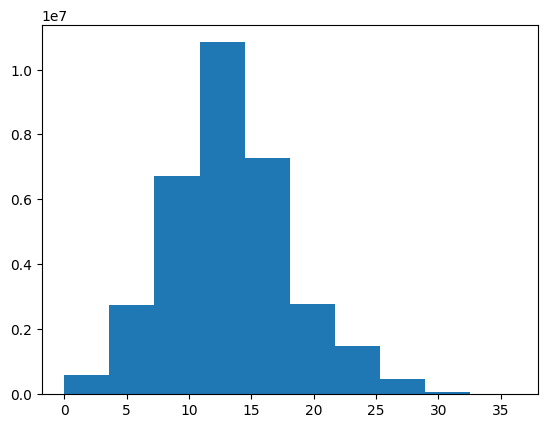

In [24]:
plt.hist(distance_matrix.flatten())

In [25]:
np.max(distance_matrix)

36.1497864423026

In [23]:
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [26]:
masked_distance_matrix = distance_matrix * 1.*(distance_matrix <= 5)

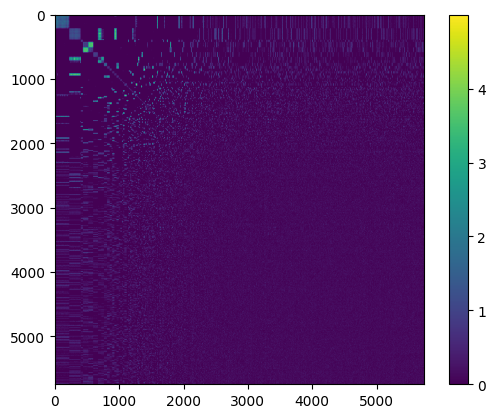

In [27]:
plt.imshow(masked_distance_matrix)
plt.colorbar()

In [28]:
# distance_matrix = normalize(distance_matrix)

In [29]:
num_galaxies = subhalos['count']
edge_list = []
for i in range(num_galaxies):
    for j in range(i):
        if masked_distance_matrix[i][j] > 0:
            edge_list.append((i, j, distance_matrix[i][j]))
        # edge_list.append((j, i, distance_matrix[i][j])) # for directed graph hack

In [30]:
len(edge_list)

640179

In [31]:
G = nx.Graph()
G.add_nodes_from(np.arange(subhalos['count']))
ebunch = [(i[0], i[1], i[2]) for i in edge_list]
G.add_weighted_edges_from(ebunch)

In [32]:
# import nx_parallel

In [41]:
shortest_path_lengths_matrix = np.zeros((subhalos['count'], subhalos['count']))
for i in range(subhalos['count']):
    d = dict(nx.shortest_path_length(G, source=i, weight='weight'))
    # print(i)
    for j in range(i):
        if j in d.keys():
            shortest_path_lengths_matrix[i][j] = d[j]
            shortest_path_lengths_matrix[j][i] = d[j]

In [42]:
t = time.time()
# d = dict(nx.shortest_path_length(G, weight='weight'))
# d = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight', backend='parallel'))

print(time.time() - t)

0.00011086463928222656


In [43]:
# shortest_path_lengths_matrix = np.zeros((subhalos['count'], subhalos['count']))
# for i in range(subhalos['count']):
#     for j in range(subhalos['count']):
#         if j in d[i].keys():
#             shortest_path_lengths_matrix[i][j] = d[i][j]

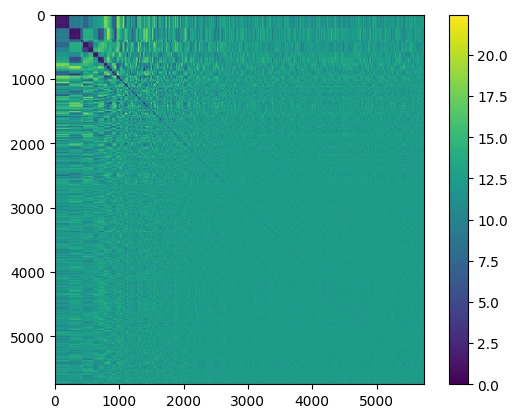

In [46]:
plt.imshow(shortest_path_lengths_matrix)
plt.colorbar()

In [47]:
D = shortest_path_lengths_matrix
C = np.eye(subhalos['count']) - (1 / subhalos['count'])*np.ones_like(shortest_path_lengths_matrix)
B = -0.5 * np.matmul(C, np.matmul(D, C))

In [48]:
evals, evecs = np.linalg.eig(B)

In [54]:
sum(evals[:10] > 0)

8

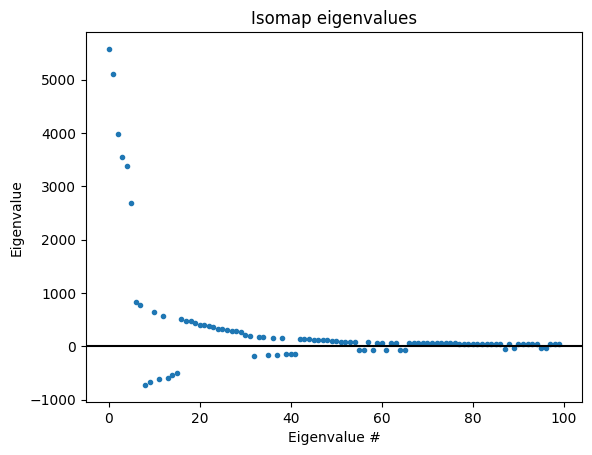

In [78]:
f = plt.figure()
plt.plot(evals[:100],'.')
plt.axhline(0, c='k')
plt.xlabel("Eigenvalue #")
plt.ylabel("Eigenvalue")
plt.title("Isomap eigenvalues")
plt.show()
f.savefig("isomap_eigenvalues.pdf")

In [56]:
evecs.shape

(5745, 5745)

In [96]:
num_to_keep = 8
X = np.matmul(evecs[:,:num_to_keep], scipy.linalg.sqrtm(np.eye(num_to_keep) * evals[:num_to_keep]))

In [97]:
X.shape

(5745, 8)

In [98]:
pca = PCA(n_components=3)
pca.fit(np.real(X.T))
print(pca.explained_variance_ratio_)

[0.23866842 0.20909715 0.16838577]


In [99]:
pca.components_.shape

(3, 5745)

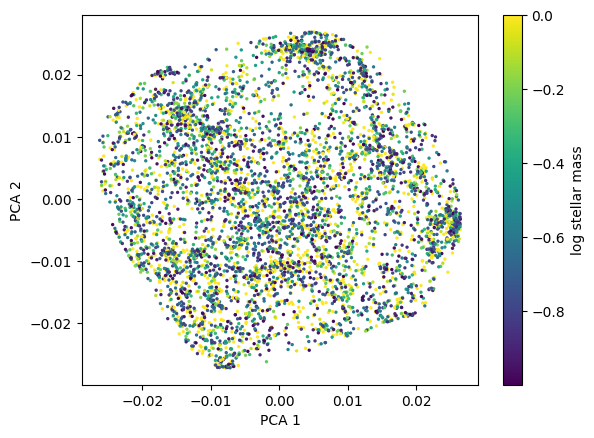

In [100]:
plt.scatter(pca.components_[0], pca.components_[1], c = np.log10(subhalos['SubhaloMassType'][:,4]),s=2, vmax=0)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log stellar mass")
plt.show()

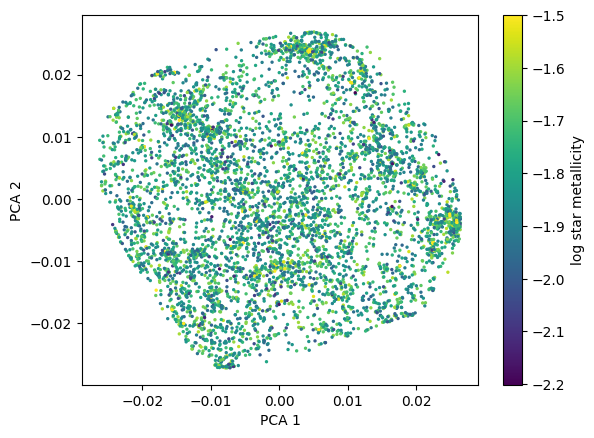

In [101]:
plt.scatter(pca.components_[0], pca.components_[1], c = np.log10(subhalos['SubhaloStarMetallicity']),s=2, vmax=-1.5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log star metallicity")
plt.show()

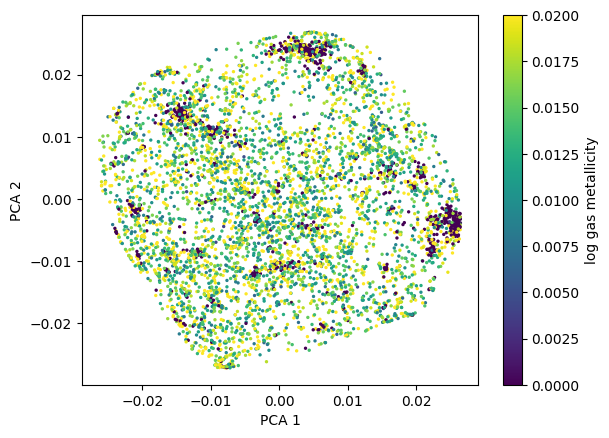

In [116]:
f = plt.figure()
plt.scatter(pca.components_[0], pca.components_[1], c = subhalos['SubhaloGasMetallicity'],s=2, vmax=0.02)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log gas metallicity")
plt.show()
f.savefig("gas_metallicity_embedding.pdf")

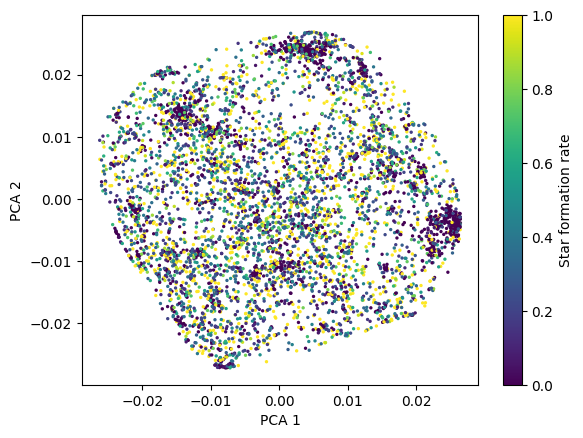

In [114]:
f = plt.figure()
plt.scatter(pca.components_[0], pca.components_[1], c = subhalos['SubhaloSFR'],s=2, vmax=1)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Star formation rate")
plt.show()
f.savefig("SFR_embedding.pdf")

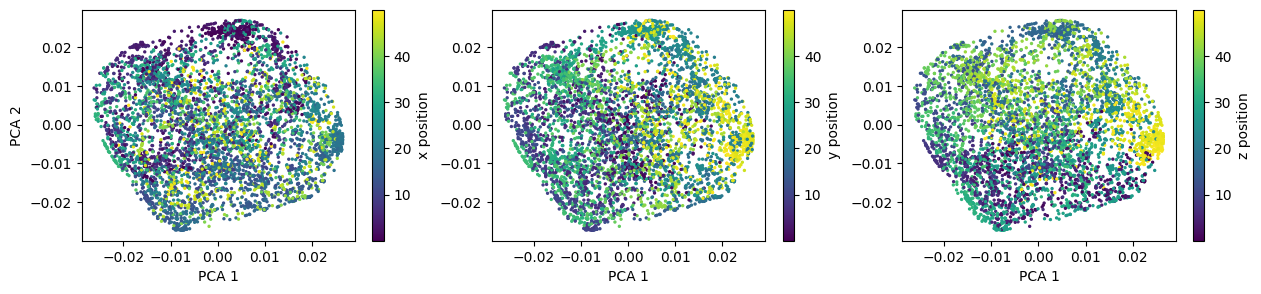

In [104]:
l = ["x", "y", "z"]
fig, ax = plt.subplots(1, 3, figsize=(15,3))
for i in range(3):
    l2 = ax[i].scatter(pca.components_[0], pca.components_[1], c = subhalos['SubhaloPos'][:,i],s=2)
    ax[i].set_xlabel("PCA 1")
    ax[0].set_ylabel("PCA 2")
    plt.colorbar(l2 ,label=l[i]+" position", ax=ax[i])
    # plt.show()

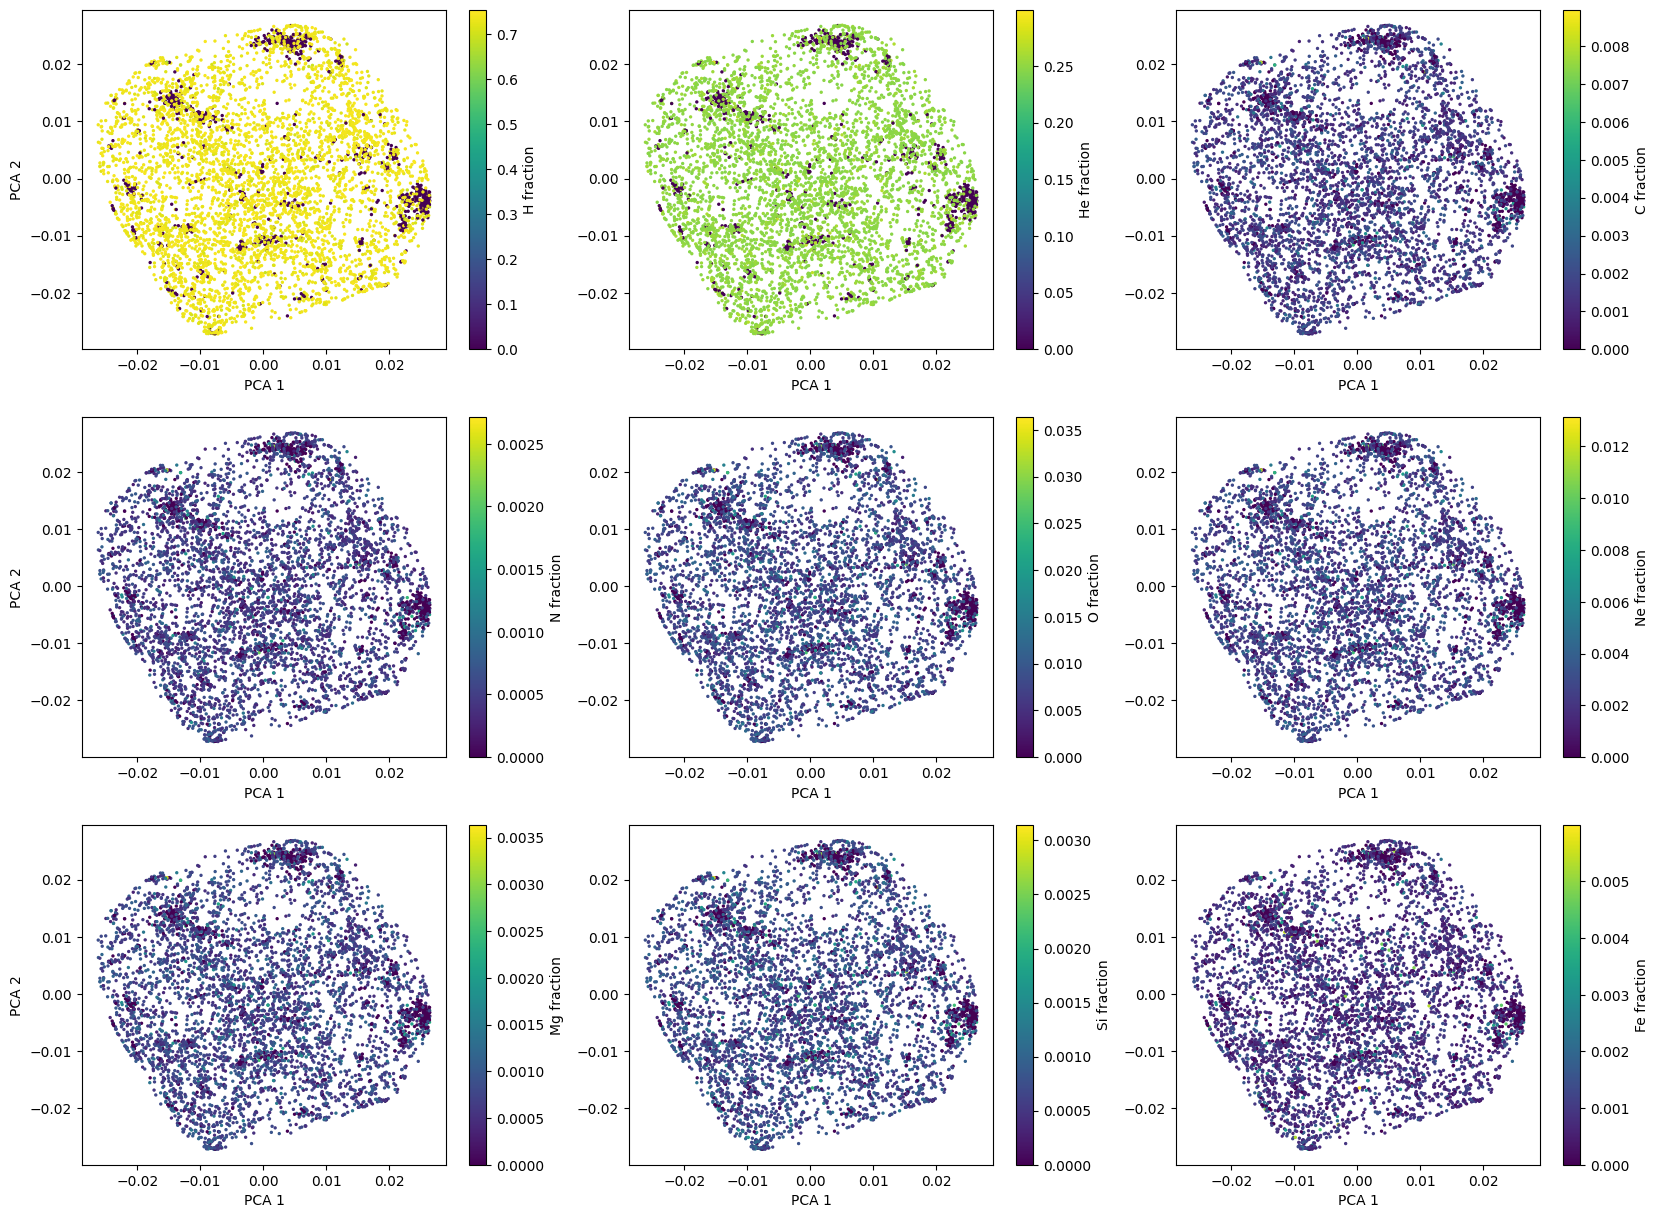

In [105]:
gases = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe', 'total']
fig, ax = plt.subplots(3, 3, figsize=(20,15))
index = 0
for i in range(3):
    for j in range(3):
        l2 = ax[i][j].scatter(pca.components_[0], pca.components_[1], c =subhalos['SubhaloGasMetalFractions'][:,index],s=2)
        ax[i][j].set_xlabel("PCA 1")
        ax[i][0].set_ylabel("PCA 2")
        plt.colorbar(l2 ,label=gases[index]+" fraction", ax=ax[i][j])
        index += 1

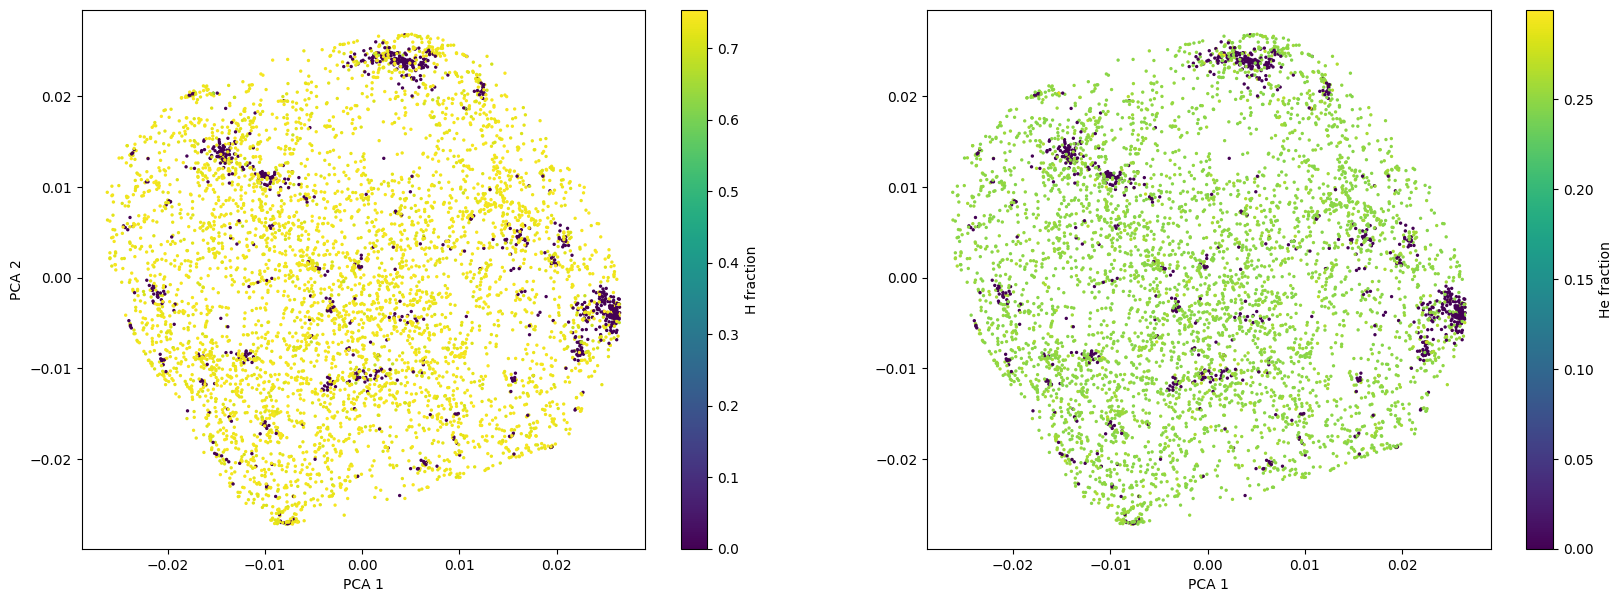

In [106]:
gases = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe', 'total']
fig, ax = plt.subplots(1, 2, figsize=(20,7))
index = 0
for i in range(2):
    l2 = ax[i].scatter(pca.components_[0], pca.components_[1], c =subhalos['SubhaloGasMetalFractions'][:,index],s=2)
    ax[i].set_xlabel("PCA 1")
    ax[0].set_ylabel("PCA 2")
    plt.colorbar(l2 ,label=gases[index]+" fraction", ax=ax[i])
    index += 1

In [107]:
fig.savefig("H_He_embedding.pdf")

limit connections to be within 150 MPc (this is where distance metrics don't matter)

In [117]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
# df = px.data.iris()
fig = px.scatter_3d(x=subhalos['SubhaloPos'][:,0], y=subhalos['SubhaloPos'][:,1], z=subhalos['SubhaloPos'][:,2],
                    color=pca.components_[0])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
plot(fig, filename='galaxies.html', auto_open=True)


'galaxies.html'

In [119]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
# df = px.data.iris()
fig = px.scatter_3d(x=subhalos['SubhaloPos'][:,0], y=subhalos['SubhaloPos'][:,1], z=subhalos['SubhaloPos'][:,2],
                    color=pca.components_[1])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
plot(fig, filename='galaxies2.html', auto_open=True)

'galaxies2.html'

In [58]:
np.savetxt('tng50_edgelist.txt', edge_list, fmt='%d')

In [20]:
nodes, *emb = np.loadtxt("struc2vec/emb/tng_bigger.emb", skiprows=1).T

emb = np.array(emb)
nodes = np.array(nodes, dtype=np.int32)
emb = emb[:,np.argsort(nodes)] # put these in the same order as the original nodes

In [21]:
emb.shape

(50, 5745)

In [22]:
pca = PCA(n_components=3)
pca.fit(emb)
print(pca.explained_variance_ratio_)

[0.37430101 0.01627728 0.01597304]


In [23]:
components = MinMaxScaler().fit_transform(pca.components_.T).T

(array([  17.,   27.,  148.,  703., 1599., 1817., 1061.,  309.,   55.,
           9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

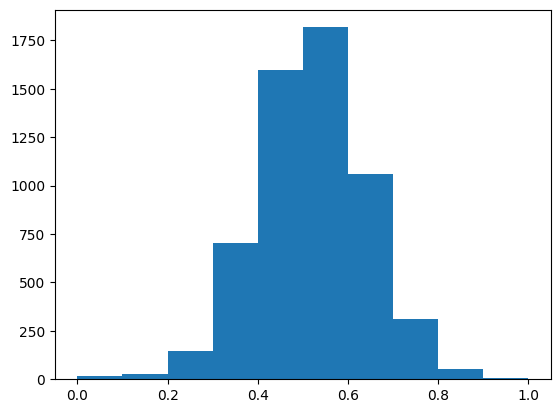

In [24]:
plt.hist(components[0])

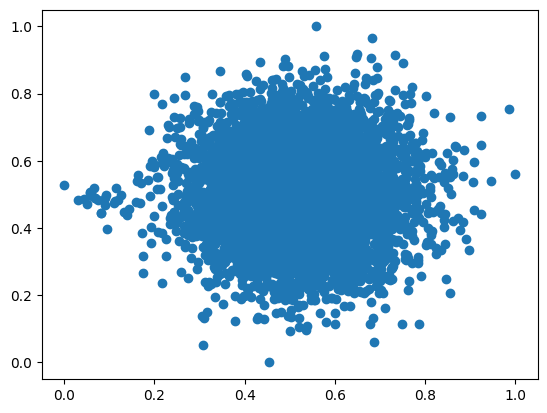

In [25]:
plt.plot(*components[[0,1]], 'o')

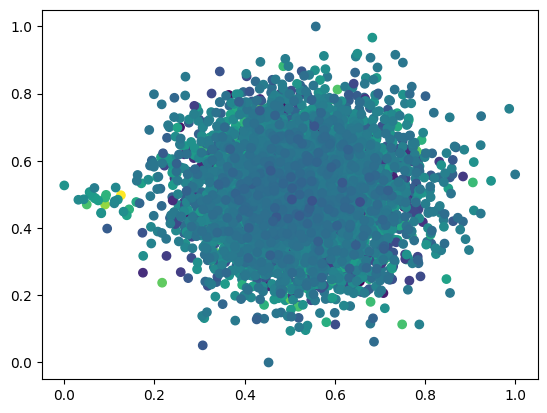

In [26]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloMass']))

In [27]:
subhalos['SubhaloLenType'][:,1]

array([46136876,  6297959,  1420531, ...,     5159,     3954,     4680],
      dtype=int32)

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_69196/465684355.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloLenType'][:,0]))


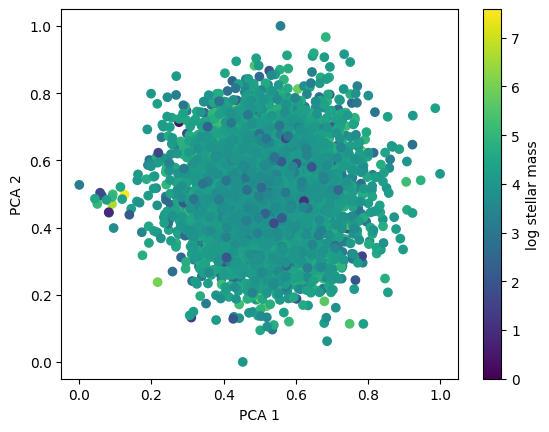

In [28]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloLenType'][:,0]))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log stellar mass")

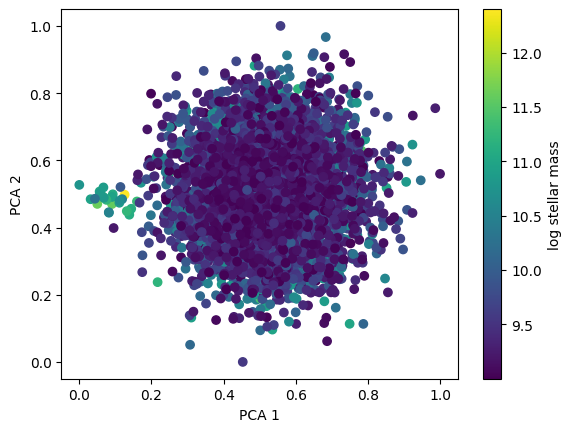

In [29]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloMassType'][:,4] * 1e10))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log stellar mass")

In [30]:
subhalos.keys()

dict_keys(['count', 'SubhaloFlag', 'SubhaloMass', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions'])

In [31]:
subhalos['SubhaloStarMetallicity']

array([0.02862233, 0.02126505, 0.02540692, ..., 0.01047968, 0.01409606,
       0.01055776], dtype=float32)

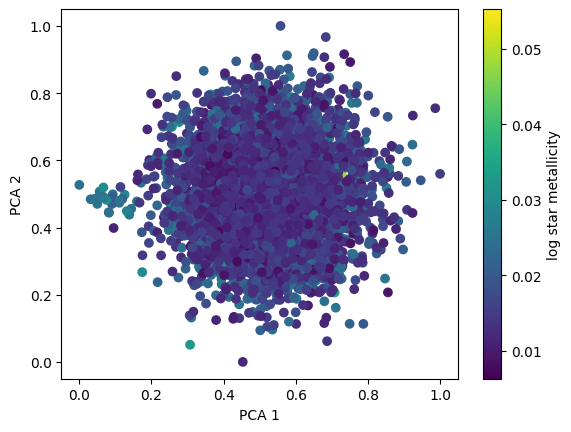

In [40]:
plt.scatter(*components[[0,1]], c = subhalos['SubhaloStarMetallicity'])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log star metallicity")

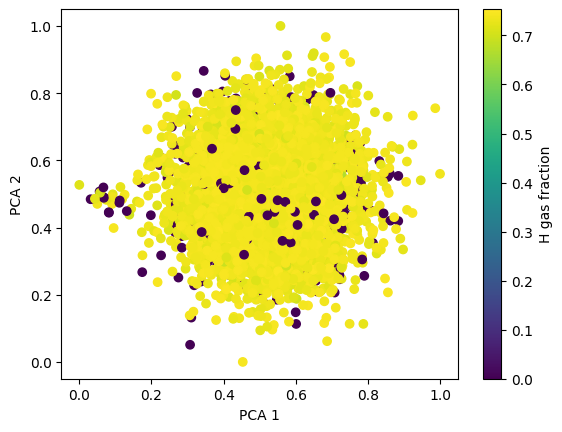

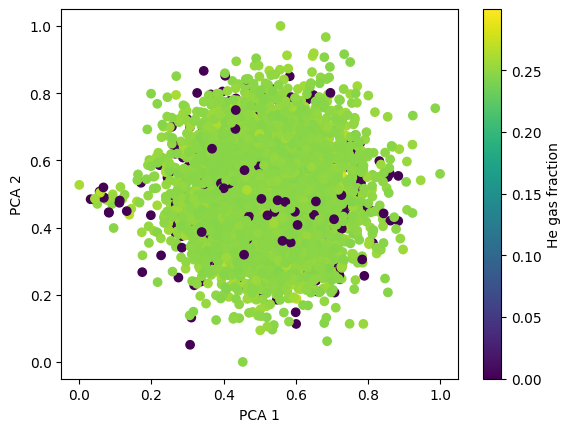

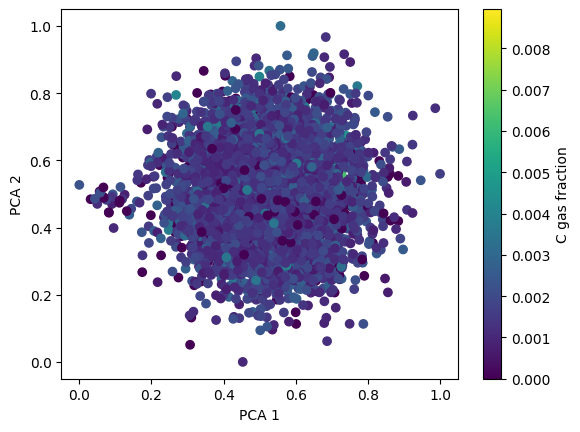

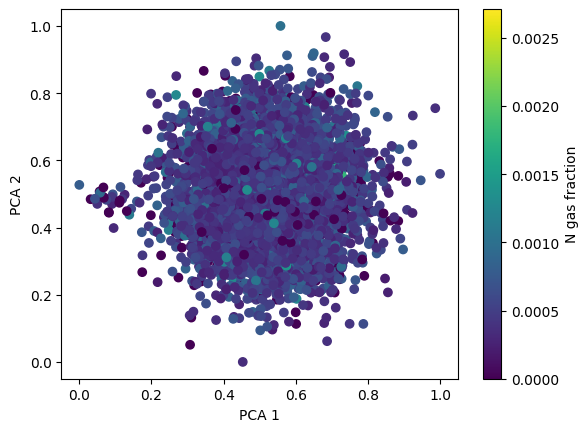

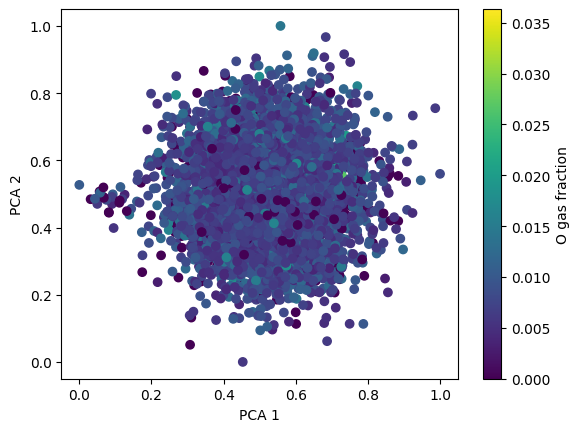

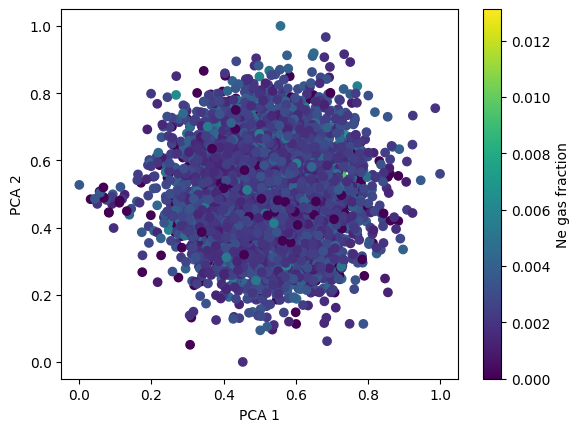

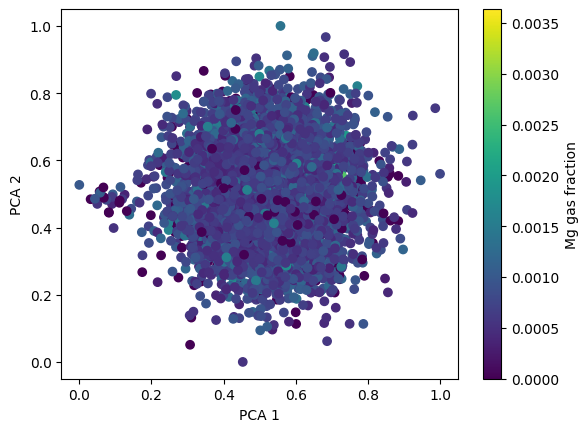

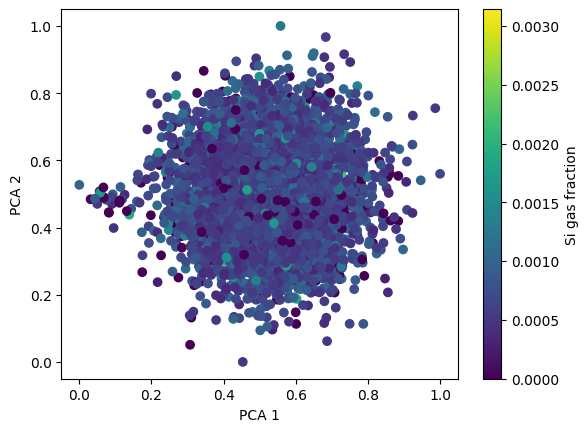

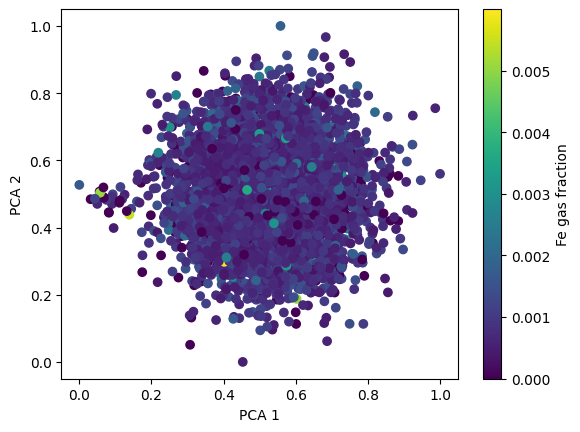

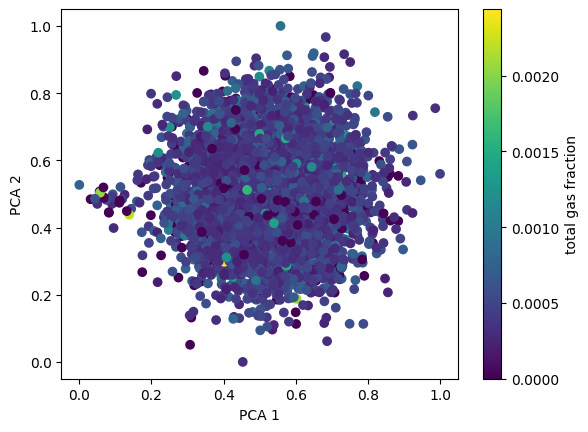

In [33]:
gases = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe', 'total']
for i in range(10):
    fig, ax = plt.subplots()
    s = ax.scatter(*components[[0,1]], c = subhalos['SubhaloGasMetalFractions'][:,i])
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    cbar = fig.colorbar(s, label=gases[i]+" gas fraction")
    plt.show()

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_69196/4242542965.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloGasMetallicity']))


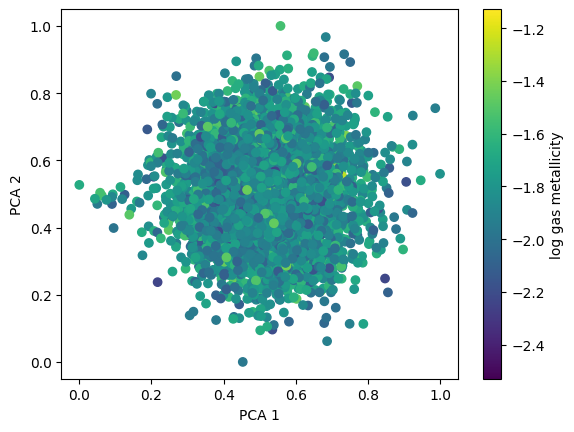

In [34]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloGasMetallicity']))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log gas metallicity")

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_69196/3560304120.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloSFR']))


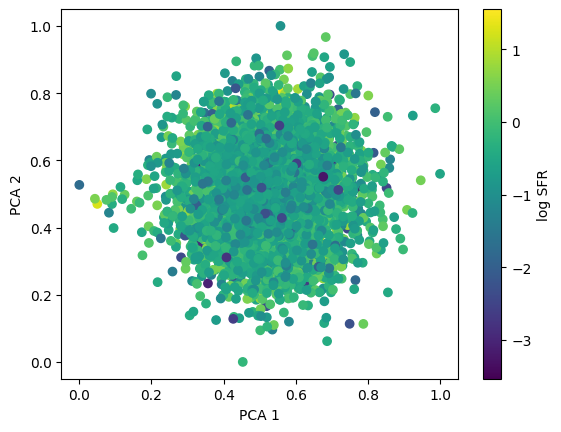

In [35]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloSFR']))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log SFR")

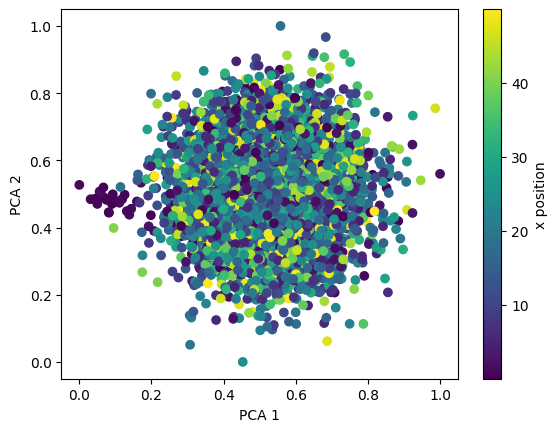

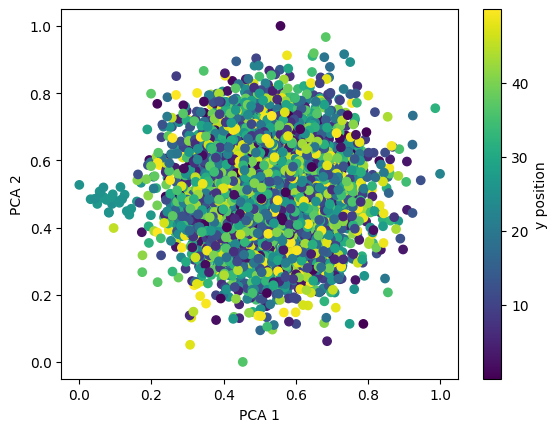

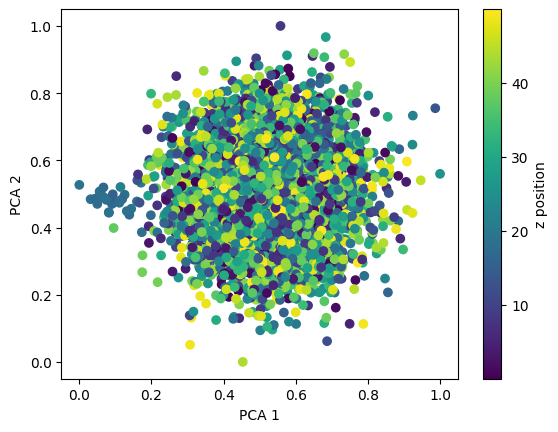

In [36]:
l = ["x", "y", "z"]
for i in range(3):
    plt.scatter(*components[[0,1]], c = subhalos['SubhaloPos'][:,i])
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label=l[i]+" position")
    plt.show()

In [39]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
# df = px.data.iris()
fig = px.scatter_3d(x=subhalos['SubhaloPos'][:,0], y=subhalos['SubhaloPos'][:,1], z=subhalos['SubhaloPos'][:,2],
                    color=np.clip(components[0], 0.2, 1))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
plot(fig, filename='galaxies.html', auto_open=True)


'galaxies.html'

distance to the boundary

plot positions and color by altent representation

weights by inverse square of distance

In [589]:
G = nx.Graph()
G.add_nodes_from(np.arange(subhalos['count']))

In [590]:
# ebunch = [(i[0], i[1], {'weight':i[2]}) for i in edge_list[::2]]
ebunch = [(i[0], i[1], i[2]) for i in edge_list[::2]]
G.add_weighted_edges_from(ebunch)

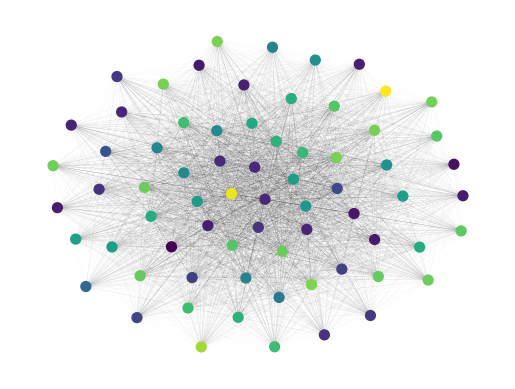

In [592]:
fig, ax = plt.subplots()
num_nodes = 70
subgraph = G.subgraph(np.arange(num_nodes))
nx.draw(subgraph, node_size=50, ax = ax, width = list(nx.get_edge_attributes(subgraph, "weight").values()), node_color = components[0][:num_nodes])

In [593]:
cmap = mpl.colormaps['Spectral']

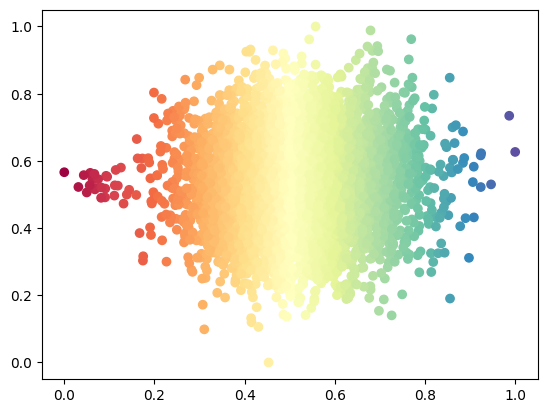

In [594]:
f = plt.scatter(components[0], components[1], c =components[0], cmap=cmap)

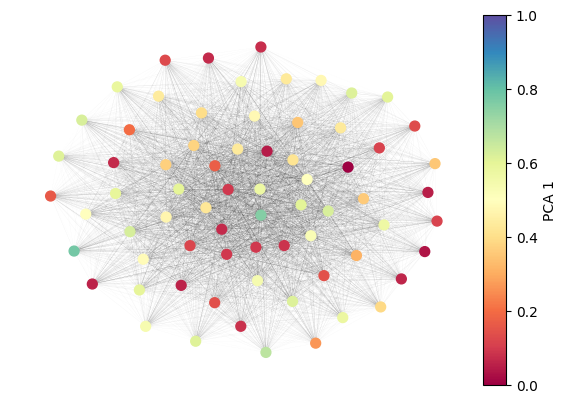

In [595]:
fig,ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
nx.draw(subgraph, pos = nx.spring_layout(subgraph), node_size=50, ax = ax, width = list(nx.get_edge_attributes(subgraph, "weight").values()), node_color = cmap(components[0][:num_nodes]))
cbar = plt.colorbar(f, cax=cax)
cbar.set_label("PCA 1")
plt.show()

In [352]:
# filename = "snap_099.0.hdf5"
# with h5py.File(filename, "r") as f:
#     # Print all root level object names (aka keys) 
#     # these can be group or dataset names 
#     print("Keys: %s" % f.keys())
#     # get first object name/key; may or may NOT be a group
#     a_group_key = list(f.keys())[0]
#     for key in f.keys():
#         print(key)
#         print(list(f[key]))
    
#     print(type(f[a_group_key])) 
